<a name="top"> <h1>2. Feature Engineering</h1> <a>

<p>Yelp Dataset- Stars Prediction<br />
<strong>Aprendizaje Autom&aacute;tico</strong><br />
<strong>Master Universitario en Ciencia de Datos</strong></p>

<p>&nbsp;</p>

<p style="text-align:right">Antonio Nogués Podadera (<em>antonio.nogues@cunef.edu</em>)</p>
<p style="text-align:right">V&iacute;ctor Viloria V&aacute;zquez (<em>victor.viloria@cunef.edu</em>)</p>


<hr style="border:1px solid gray">

### Estructura

[0. Introducción](#introduccion) 


[1. Librerias y funciones](#librerias) 


[2. Tratamiento de valores Nulos](#outliers) 

   
[3. Creación de Pipelines](#pipelines) 

   - Listas de variables 
   - Pipelines según el tipo de variable
   - Pipeline de preprocesado
   
   
[4. Selección de variables](#variables)

[5. Separación en Train, Validación y Test](#sets)

   - Análisis estadístico de train, validación y test

<hr style="border:1px solid gray">

# <a name="introduccion"> 0. Introducción <a> 

En este documento se realizarán diferentes transformaciones en el dataframe que posteriormente utilizará el modelo de Machine Learning. Para ello nos basaremos en el archivo que previamente se ha exportado en el análisis exploratorio de datos (EDA).

# <a name="librerias"> 1. Librerias y funciones <a> 

## 1.1. Importación de librerias

In [16]:
# Ignore the warnings

import warnings
warnings.filterwarnings('ignore')


# Import basic libraries.

import pandas as pd
import seaborn as sns

# Import pipelines and encoders libraries.

from category_encoders import TargetEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split 

## 1.2. Importación de funciones

In [17]:
# Importing the functions:

from aux_functions import *
from transformations import replace_nan_values

# <a name="outliers"> 2. Estudio de Outliers <a> 

Tal y como vimos durante el análisis exploratorio (`01_EDA`), comprobamos la existencia de valores atípicos.

In [18]:
# Load the processed dataset saved in the EDA.

restaurants_df = pd.read_parquet('../data/processed/restaurants_df.parquet')

# Select the numeric variables to save them in the new dataframe 'num_var_df'. Variables that start by 'total_' and 'review_count'.

num_var_df = restaurants_df[[col for col in restaurants_df.columns if col.startswith('total_') or col.startswith('review_count')]]

# Obtain the outliers of the 'num_var_df' dataset.

outliers = get_outliers(num_var_df)

# Display number of rows withous NaN values.

print(outliers.count().sort_values(ascending=False))


total_checkins           3850
review_count             3368
total_hours_Thursday     1836
total_hours_Wednesday    1799
total_hours_Tuesday      1795
total_hours_Sunday       1783
total_hours_Friday       1682
total_hours_Saturday     1674
total_hours_Monday          0
dtype: int64


Como vimos, principalmente destacan las variables `total_checkins` y `review_count` debido a su mayor nº de outliers. Por lo que procedemos a echar un vistazo a cada variable individualmente

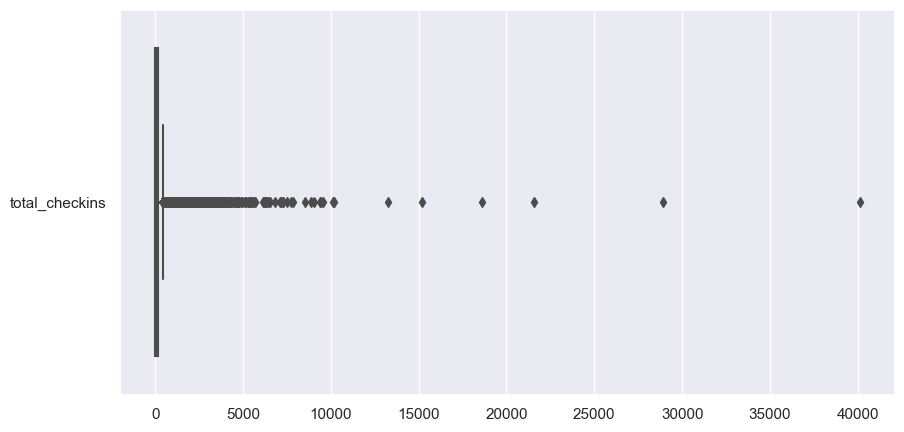

In [19]:
# Config size of the plot.

sns.set(rc={'figure.figsize':(10,5)})

# Create a boxplot of 'user_number'.

sns.boxplot(data=restaurants_df[['total_checkins']], orient="h")

# Display the plot.

plt.show()

Observamos como al existir un gran número de locales los checkins varían bastante, sin mbargo, estos outliers no es preocupante, dado que es algo normal que el volumen de gente varíe según la popularidad del restaurante. Es por ello que dejaremos los valores intactos, dado que no afectan al modelo

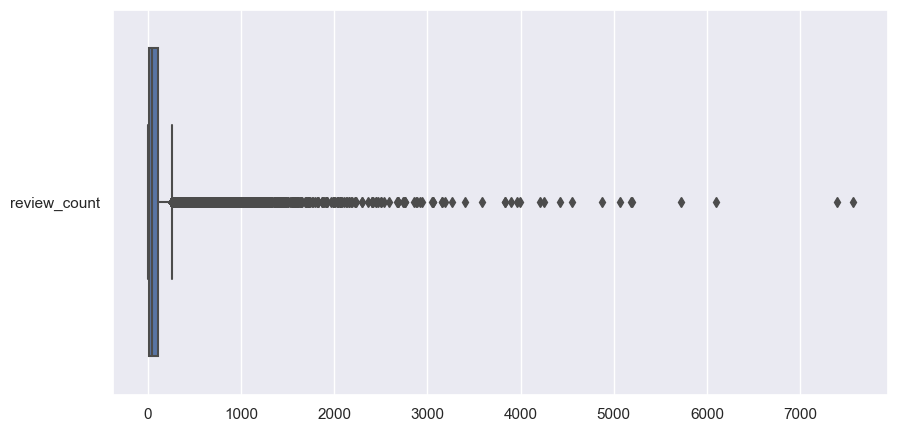

In [20]:
# Config size of the plot.

sns.set(rc={'figure.figsize':(10,5)})

# Create a boxplot of 'user_number'.

sns.boxplot(data=restaurants_df[['review_count']], orient="h")

# Display the plot.

plt.show()

Al igual que en el caso de checkins, la popularidad de un restaurante puede ser mayor que otras por lo que influye al tráfico de clientes, incrementando el nº de reviews publicadas. Es por ello que dejaremos los valores intactos, dado que no afectan al modelo

# <a name="librerias"> 3. Tratamiento de valores nulos <a> 

In [21]:
# Load the processed dataset saved in the EDA.

restaurants_df = pd.read_parquet('../data/processed/restaurants_df.parquet')

# Calculate the null values for each row.

null_count = restaurants_df.isnull().sum().sort_values(ascending=False)

# Print the null values.

print(null_count)

attributes_AcceptsInsurance                  34501
attributes_RestaurantsCounterService         34500
attributes_DietaryRestrictions_dairy-free    34498
attributes_DietaryRestrictions_kosher        34498
attributes_DietaryRestrictions_vegan         34498
                                             ...  
longitude                                        0
latitude                                         0
state                                            0
city                                             0
total_checkins                                   0
Length: 90, dtype: int64


El dataframe presenta una gran cantidad de valores nulos. Se ha decidido sustituir todos los valores nulos por el valor 0. Esto se debe a que hemos considerado que si no tenemos determinada información de un atributo es porque el restaurante no lo ha proporcionado para preservar el número de estrellas que tiene.

In [22]:
# Replace the NaN values with 0

restaurants_df = restaurants_df.fillna(0)

# Check the dataset

null_count = restaurants_df.isnull().sum()

null_count

business_id             0
name                    0
city                    0
state                   0
latitude                0
                       ..
total_hours_Thursday    0
total_hours_Friday      0
total_hours_Saturday    0
total_hours_Sunday      0
total_checkins          0
Length: 90, dtype: int64

# <a name="librerias"> 3. Selección de variables <a> 

Para la creación del modelo , **prescindiremos de las variables identificativas dado que no son relevantes para nuestro modelo, las cuales son : `business_id` y `name`.** 

Además **eliminaremos algunas variables relacionadas con la ubicación de cada restaurante, como `latitude`, `longitude` y `city`**. Consideramos que con la variable `state` es suficiente y permitirá al modelo reducir carga computacional.

Eliminaremos también la variable `is_open` dado que al seleccionar en el EDA los restaurantes abiertos ya no tiene sentido conservarla.

In [23]:
# Drop the columns 'business_id', 'name', 'latitude', 'longitude' and 'city' because they are not relevant for the model.

restaurants_df = restaurants_df.drop(['business_id', 'name', 'latitude', 'longitude', 'city', 'is_open'], axis=1)


# <a name="librerias"> 4. Creación de Pipelines <a> 

En este apartado crearemos un pipelines de preprocesado para aplicar la transformación de las variables previamente a realizar los modelos. Este pipeline, diferenciará segun el tipo de variable: numérica oo categórica.

### 4.1. Listas de variables

Dado que tenemos diferentes tipos de variables, creamos dos listas para diferenciarlas y tratarlas posteriormente de forma diferente.  

`categorical_variables_df` para las varaibles categóricas.

`num_var_df` para las variables numéricas.

In [24]:
# Create a dataframe with all the categorical variables.

categorical_variables = restaurants_df[[col for col in restaurants_df.columns if not col.startswith('total_') and not col.startswith('review_count') and not col.startswith('stars')]]

# Create a dataframe with all the numerical variables.

num_var_df = restaurants_df[[col for col in restaurants_df.columns if col.startswith('total_') or col.startswith('review_count')]]

Observamos los valores únicos de las variables categóricas.

In [25]:
# Create a DF with categorical_variables as rows and the number of unique values and distinct values as columns.

categorical_variables_df = pd.DataFrame(columns=['unique_values', 'distinct_values'])

for i in categorical_variables:
    categorical_variables_df.loc[i, 'unique_values'] = restaurants_df[i].nunique()
    categorical_variables_df.loc[i, 'distinct_values'] = restaurants_df[i].unique().tolist()

# Show the categorical variables with more than 2 unique values.

categorical_variables_df[categorical_variables_df['unique_values'] > 2]

,unique_values,distinct_values
state,16,"[PA, TN, FL, IN, NV, IL, NJ, CA, LA, DE, MO, A..."
attributes_RestaurantsPriceRange2,5,"[1.0, 0.0, 2.0, 3.0, 4.0]"
attributes_WiFi,4,"[free, no, nan, paid]"
attributes_Alcohol,3,"[nan, full_bar, beer_and_wine]"
attributes_RestaurantsAttire,4,"[nan, casual, dressy, formal]"
attributes_NoiseLevel,5,"[nan, average, quiet, loud, very_loud]"
attributes_Smoking,4,"[nan, no, outdoor, yes]"
attributes_BYOBCorkage,4,"[nan, yes_free, no, yes_corkage]"
attributes_AgesAllowed,3,"[nan, all_ages, 21_plus]"


Sin embargo, dentro de las variables categóricas, existen algunas con valores de tipo string, las cuales agruparemos por separado en `list_cat_string` para tratar de forma diferente sus NaN. 

In [26]:
cat_var_string = ['attributes_WiFi','attributes_Alcohol','attributes_RestaurantsAttire', 'attributes_NoiseLevel','attributes_Smoking','attributes_BYOBCorkage','attributes_AgesAllowed']

# Drop from categorical_variables the columns that are in list_cat_string.

cat_var = categorical_variables.drop(cat_var_string, axis=1)

# Convert the columns of cat_var to list.

cat_var = cat_var.columns.to_list()

### 4.2. Pipelines según el tipo de variable

#### 4.2.1 Variables categóricas numéricas

Para las variables categóricas numéricas (`cat_var`), **en primer lugar, transformará los valores nulos a 0**. Esto se debe a que hemos considerado que si no tenemos determinada información de un atributo es porque el restaurante no lo dispone, dado que si el restaurante lo tuviera, lo agregaría para atraer más clientes. 

**Posteriormente según el número de categorías internas dentro de cada variable, realizaremos una transformación mediante One Hot Encoder (máx 5) o Mean Encoding (Más de 5)**, One Hot es ideal para categorías con pocos grupos, mientras que cuando tenemos grupos más grandes es mejor usar Mean Encoding.

In [27]:
# Separate cat_var in two lists, depending if the variables have more or less than 5 different values.

cat_var_short = [col for col in cat_var if restaurants_df[col].nunique() <= 5]

cat_var_long = [col for col in cat_var if restaurants_df[col].nunique() > 5]

In [28]:
# Creation of a pipeline for short categorical variables that fills NaN values to '0' first,
# then apply the OneHotEncoder preprocessing.

short_cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])


In [29]:
# Creation of a pipeline for long categorical variables that fills NaN values to '0' first,
# then apply the target encoder preprocessing.

long_cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
    ('target', TargetEncoder(handle_unknown='ignore'))])

#### 4.2.2 Variables categóricas string

Para las variables categóricas con texto (`cat_var_string`), **en primer lugar, transformará los valores nulos al grupo 'no'**. Esto se debe a que hemos considerado que si no tenemos determinada información de un atributo es porque el restaurante no dispone de ello, por lo que lo agregamos a una nueva variable.

**Posteriormente debido al bajo número de categorías internas (máx 5) dentro de cada variable, realizaremos una transformación mediante One Hot Encoder**, ideal para categorías con pocos grupos.

In [30]:
# Creation of a pipeline for categorical variables that fill NaN values to 'no' first,
# then apply the OneHotEncoder preprocessing.

string_cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='no')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

#### 4.2.4 Variables numéricas

En cuanto a las variables numéricas, observamos en el EDA que **no existian valores nulos** en este tipo de variables, por lo que no será necesario ninguna transformación en cuanto a ese tipo de datos. 

Sin embargo, **realizaremos un preprocesado de estandarización**, para que los **datos sean internamente coherentes y permita una mayor eficiencia en la optimización del modelo**.

In [31]:
# Create a list with the names of the columns of the numerical variables

num_var = num_var_df.columns.to_list()

In [32]:
# Creation of a pipeline for numerical variables that standardize each variable

num_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

### 4.3 Pipeline de preprocesado

Una vez creados los diferentes pipelines para cada tipo de variable, los unificaremos en un Preprocesador, que transformará las variables previamente al entrenamiento de los modelos.

In [33]:
# Creation of a preprocessor for the categorical and numerical variables.

preprocessor = ColumnTransformer(
    transformers=[
        ('short_cat', short_cat_transformer, cat_var_short),
        ('long_cat', long_cat_transformer, cat_var_long),
        ('string_cat', string_cat_transformer, cat_var_string),
        ('num', num_transformer, num_var)
    ]
)

# Save the preprocessor as .pickle.

with open('../models/preprocessor.pickle', 'wb') as f:
    pickle.dump(preprocessor, f)

## <a name="sets"> 5. Separación en Train, Validación y Test <a>

Una vez realizado el EDA, procedemos a crear los diferentes sets de train, validacion y test. De manera que **para la creación de nuestros modelos de Machine Learning dispondremos de 3 sets: train, validación y test**.

En primer lugar separamos los distintos valores (X) de la variable objetivo (Y)

In [34]:
# Separation of variables X  from the target variable Y (stars)

X = restaurants_df.drop('stars', axis=1).reset_index(drop=True)
Y = restaurants_df['stars'].reset_index(drop=True)

Creamos el set de Test:

In [35]:
# Division into train and test sets.

x_train_all, x_test, y_train_all, y_test = train_test_split(X, Y, test_size=0.25, random_state=12345)

Creamos el set de train y validación:

In [36]:
# Creation of a validation set shuffled from the training set. Selecting a 25% of the total for the 'val_df'.

x_train, x_val, y_train, y_val = train_test_split(x_train_all, y_train_all, test_size=0.25, random_state=12345, stratify=y_train_all)

Cambiamos el formato de `y_train`, `y_val`, `y_test` e `y_train_all` a dataframe, para poder guardarlo posteriormente en Parquet.

In [37]:
# Convert y_train and y_val to a dataframe.

y_train = pd.DataFrame(y_train)
y_val = pd.DataFrame(y_val)
y_train_all = pd.DataFrame(y_train_all)
y_test = pd.DataFrame(y_test)


Exportamos los sets como Parquet para poder cargarlos en la elaboración de los modelos.

In [63]:
# Export the train, validation and test variables as Parquet in the folder of processed data.

x_train.to_parquet("../data/processed/x_train.parquet")
y_train.to_parquet("../data/processed/y_train.parquet")

x_val.to_parquet("../data/processed/x_val.parquet")
y_val.to_parquet("../data/processed/y_val.parquet")

x_train_all.to_parquet("../data/processed/x_train_all.parquet")
y_train_all.to_parquet("../data/processed/y_train_all.parquet")

x_test.to_parquet("../data/processed/x_test.parquet")
y_test.to_parquet("../data/processed/y_test.parquet")

### 5.1. Análisis estadístico de train, validación y test

Una vez separados los sets, procedemos a realizar un análisis estadístico de los mismos para comprobar si presentan similitudes entre ellos (estadísticamente hablando)

In [45]:
# Describing the validation dataframe

x_val.describe()

,review_count,attributes_ByAppointmentOnly,attributes_BusinessAcceptsCreditCards,attributes_BikeParking,attributes_RestaurantsPriceRange2,attributes_CoatCheck,attributes_RestaurantsTakeOut,attributes_RestaurantsDelivery,attributes_Caters,attributes_WheelchairAccessible,...,attributes_DietaryRestrictions_soy-free,attributes_DietaryRestrictions_vegetarian,total_hours_Monday,total_hours_Tuesday,total_hours_Wednesday,total_hours_Thursday,total_hours_Friday,total_hours_Saturday,total_hours_Sunday,total_checkins
count,6472.000000,6472.000000,6472.000000,6472.000000,6472.000000,6472.000000,6472.000000,6472.000000,6472.000000,6472.000000,...,6472.000000,6472.000000,6472.000000,6472.000000,6472.000000,6472.000000,6472.000000,6472.000000,6472.000000,6472.000000
mean,105.019005,0.002936,0.828183,0.530593,1.318912,0.007880,0.874845,0.630871,0.397559,0.271786,...,0.000155,0.000309,6.291985,8.502350,8.874952,8.968473,9.309056,9.174085,7.766636,188.899258
std,217.584956,0.054107,0.377251,0.499102,0.782454,0.088426,0.330920,0.482606,0.489431,0.444915,...,0.012430,0.017578,6.087727,5.184819,4.923371,4.812793,4.937839,5.040872,5.366460,427.326848
min,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,16.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,5.000000,6.000000,6.000000,7.000000,6.000000,0.000000,16.000000
50%,40.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,7.000000,10.000000,10.000000,10.000000,10.000000,10.500000,9.000000,53.000000
75%,111.000000,0.000000,1.000000,1.000000,2.000000,0.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,11.000000,12.000000,12.000000,12.000000,12.000000,12.000000,11.000000,180.250000
max,6093.000000,1.000000,1.000000,1.000000,4.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,23.980000,23.980000,23.980000,23.980000,23.980000,23.980000,23.980000,7848.000000


In [46]:
# Describing the test dataframe

x_test.describe()

,review_count,attributes_ByAppointmentOnly,attributes_BusinessAcceptsCreditCards,attributes_BikeParking,attributes_RestaurantsPriceRange2,attributes_CoatCheck,attributes_RestaurantsTakeOut,attributes_RestaurantsDelivery,attributes_Caters,attributes_WheelchairAccessible,...,attributes_DietaryRestrictions_soy-free,attributes_DietaryRestrictions_vegetarian,total_hours_Monday,total_hours_Tuesday,total_hours_Wednesday,total_hours_Thursday,total_hours_Friday,total_hours_Saturday,total_hours_Sunday,total_checkins
count,8629.000000,8629.000000,8629.000000,8629.000000,8629.000000,8629.000000,8629.000000,8629.000000,8629.000000,8629.000000,...,8629.000000,8629.000000,8629.000000,8629.000000,8629.000000,8629.000000,8629.000000,8629.000000,8629.000000,8629.000000
mean,106.340132,0.002550,0.830108,0.526249,1.295167,0.006142,0.882026,0.639703,0.399119,0.274308,...,0.000116,0.000232,6.434868,8.627963,8.932947,8.972472,9.354585,9.221865,7.698145,201.069765
std,241.631674,0.050432,0.375560,0.499339,0.782813,0.078135,0.322596,0.480114,0.489746,0.446191,...,0.010765,0.015223,6.076824,5.145879,4.898028,4.805320,4.904766,5.028088,5.426999,615.940739
min,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,17.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,5.000000,6.000000,6.000000,7.000000,6.500000,0.000000,16.000000
50%,41.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,7.500000,10.000000,10.000000,10.000000,10.500000,10.500000,9.000000,53.000000
75%,108.000000,0.000000,1.000000,1.000000,2.000000,0.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,11.000000,12.000000,12.000000,12.000000,12.000000,12.000000,11.000000,182.000000
max,7568.000000,1.000000,1.000000,1.000000,4.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,23.980000,23.980000,23.980000,23.980000,23.980000,23.980000,23.980000,28927.000000


In [47]:
# Describe the train dataframe

x_train.describe()

,review_count,attributes_ByAppointmentOnly,attributes_BusinessAcceptsCreditCards,attributes_BikeParking,attributes_RestaurantsPriceRange2,attributes_CoatCheck,attributes_RestaurantsTakeOut,attributes_RestaurantsDelivery,attributes_Caters,attributes_WheelchairAccessible,...,attributes_DietaryRestrictions_soy-free,attributes_DietaryRestrictions_vegetarian,total_hours_Monday,total_hours_Tuesday,total_hours_Wednesday,total_hours_Thursday,total_hours_Friday,total_hours_Saturday,total_hours_Sunday,total_checkins
count,19415.000000,19415.000000,19415.000000,19415.000000,19415.000000,19415.000000,19415.000000,19415.000000,19415.000000,19415.000000,...,19415.000000,19415.000000,19415.000000,19415.000000,19415.000000,19415.000000,19415.000000,19415.000000,19415.000000,19415.000000
mean,105.180840,0.002936,0.832140,0.533814,1.304404,0.008035,0.878187,0.634097,0.405975,0.279938,...,0.000052,0.000155,6.266548,8.540458,8.887373,8.944474,9.285010,9.176793,7.705955,195.699511
std,213.865801,0.054106,0.373751,0.498868,0.787541,0.089280,0.327078,0.481695,0.491092,0.448980,...,0.007177,0.012430,6.054997,5.150593,4.884043,4.791234,4.919087,5.040424,5.374483,550.448978
min,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,16.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,5.000000,6.000000,6.000000,6.500000,6.000000,0.000000,16.000000
50%,41.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,7.000000,10.000000,10.000000,10.000000,10.250000,10.500000,9.000000,53.000000
75%,112.000000,0.000000,1.000000,1.000000,2.000000,0.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,11.000000,12.000000,12.000000,12.000000,12.000000,12.000000,11.000000,182.000000
max,7400.000000,1.000000,1.000000,1.000000,4.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,23.980000,23.980000,23.980000,23.980000,23.980000,23.980000,23.980000,40109.000000


Tras obtener los distintos estadísticos, podemos observar que **los sets de train, validación y test presentan una distribución similar en cada una de sus variables**. 

Con la media podemos afirmar que en los tres grupos cada variable es similar puesto que presentan valores muy cercanos. La desviación típica nos deja ver en variables como `total_checkins` que hay mucha dispersión entre los datos. Por último, el valor máximo y mínimo nos muestra que se alejan mucho de la media en variables como `total checkins` y `review_count`, indicándonos la presencia de outliers (analizado ya anteriormente en el EDA). 